## Recommandation system environment setting

This is a virtual [FNAC](https://en.wikipedia.org/wiki/Fnac) recommandation system environment for simulating its users preferences and orders.

<img src="imgs/Fnac_Logo.png" width="200">


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

%matplotlib inline

In [33]:
category_dict = {}
category_dict["Musique, CD, Vinyles"] = ["Variété française", "Pop, Rock, Indé", "Compilations", "Hard Rock, Métal", "R&B, Soul, Funk"]
category_dict["Jeux Vidéo, Consoles"] = ["Consoles PS4", "Jeux PS4", "Contenus PS4", "Accessoires PS4", "Cartes cadeau PS4"]
category_dict["Films, Séries TV, DVD, Blu-Ray"] = ["Comdédie", "Emotions", "Grands Classiques", "Action", "Frantastique"]
category_dict["Informatique, Tablettes"] = ["Samsung Galaxy", "iPad", "Accessoires iPad", "Macbook", "PC portable"]
category_dict["Smartphones & Objets connectés"] = ["iPhone", "Samsung", "Huawei", "Apple Watch", "Xiaomi"]
category_dict["Photo, Caméras, Tirages photo"] = ["Caméra Canon", "Caméra Sony", "Caméra Nikon", "Caméra DJI", "Caméra GoPro"]
category_dict["Son, Casques, Enceintes"] = ["Google Home", "Casque Bose", "Casque Beats", "Casque JBL", "Casque Sony"]
category_dict["Electroménager, Cuisine"] = ["Aspirateur robot", "Chauffage", "Robot cuiseur", "Mojoteur", "Brosse à dents électrique"]

reco_length = 5

In [7]:
def generate_random_category(n, m):
    category_dict = {}
    for i in range(n):
        category_dict[i] = [str(i) + "-" + str(x) for x in list(range(m))]
    return category_dict


In [8]:
#category_dict = generate_random_category(10, 20)

In [10]:
category_dict = generate_random_category(10, 20)
reco_length = 5

In [34]:
def count(dictionary):
    return sum(len(dictionary[x]) for x in dictionary.keys())

count(category_dict)

40

In [35]:
category_dict

{'Musique, CD, Vinyles': ['Variété française',
  'Pop, Rock, Indé',
  'Compilations',
  'Hard Rock, Métal',
  'R&B, Soul, Funk'],
 'Jeux Vidéo, Consoles': ['Consoles PS4',
  'Jeux PS4',
  'Contenus PS4',
  'Accessoires PS4',
  'Cartes cadeau PS4'],
 'Films, Séries TV, DVD, Blu-Ray': ['Comdédie',
  'Emotions',
  'Grands Classiques',
  'Action',
  'Frantastique'],
 'Informatique, Tablettes': ['Samsung Galaxy',
  'iPad',
  'Accessoires iPad',
  'Macbook',
  'PC portable'],
 'Smartphones & Objets connectés': ['iPhone',
  'Samsung',
  'Huawei',
  'Apple Watch',
  'Xiaomi'],
 'Photo, Caméras, Tirages photo': ['Caméra Canon',
  'Caméra Sony',
  'Caméra Nikon',
  'Caméra DJI',
  'Caméra GoPro'],
 'Son, Casques, Enceintes': ['Google Home',
  'Casque Bose',
  'Casque Beats',
  'Casque JBL',
  'Casque Sony'],
 'Electroménager, Cuisine': ['Aspirateur robot',
  'Chauffage',
  'Robot cuiseur',
  'Mojoteur',
  'Brosse à dents électrique']}

In [68]:
class Clients:
    def __init__(self, n_client, category_dict, desire_threshold=3):
        self.category_dict = category_dict
        self.category_list = list(category_dict.keys())
        self.n_client = n_client
        self.n_category = len(category_dict.keys())
        self.n_commodity = count(category_dict)
        
        self.buy_threshold_list = [desire_threshold] * n_client
        self.cart_threshold_list = [desire_threshold*0.8] * n_client
        self.click_threshold_list = [desire_threshold*0.6] * n_client
        
        
        self.preference_matrix = np.zeros((n_client, self.n_commodity))
        self.desire_matrix = copy.copy(self.preference_matrix)
        
        self.reward_history = []
        self.revenue_history = []
        self.regret_history = []  # only revenue 
        self.regret_moreinfo_history = [] # revenue, cart, click
        self.reward_sum_each_step = []
        
        self.generate_client_distribution()
        
    def generate_client_distribution(self):
        proba_category = np.random.uniform(0, 0.9, (self.n_client, self.n_category))
        proba_commodity_list = []
        for j in range(proba_category.shape[1]):
            #print('---aaa---', np.expand_dims(proba_category[:,j],1).shape)
            proba_commodity_list.append(np.repeat(np.expand_dims(proba_category[:,j],1), len(self.category_dict[self.category_list[j]]), axis=1))
        self.preference_matrix = np.hstack(proba_commodity_list)
        #print(proba_commodity_list[0].shape)
        #print(proba_commodity_list[1].shape)
        #print(self.proba_commodity.shape)
        self.preference_matrix += np.random.uniform(0, 0.1, (self.n_client, self.n_commodity))
        return
    
    def get_clients(self, n):
        return np.random.choice(list(range(self.n_client)), n, replace=False)
    
    def update_desire(self, client, rate_rise=None):
#         if rate_decay is not None:
#             self.desire_matrix *= 1 - rate_decay
        
        # if a commodity's desire has been over the thresholf for a long time but not buy things at our site,
        # the client may probably buy it somewhere else, so its desire will decrease to 0
        for i in range(len(self.desire_matrix[client])):
            if self.desire_matrix[client][i] > 3*self.buy_threshold_list[client]:
                self.desire_matrix[client][i] = 0  
        
        if rate_rise is None:
            rate_rise = np.mean(self.desire_threshold_list) * 0.5
        if rate_rise < 0:
            rate_rise = 0
        self.desire_matrix[client] += rate_rise * self.preference_matrix[client]
    
    def get_waiting_list(self, client):
        client_desire = self.desire_matrix[client]
        buy = np.array(np.where(client_desire>self.buy_threshold_list[client])[0])
        cart = np.array(np.where(client_desire>self.cart_threshold_list[client])[0])
        click = np.array(np.where(client_desire>self.click_threshold_list[client])[0])
        #print('click', click)
        
        for i in range(len(click)):
            if click[i] in cart:
                click[i] = 0
        
        for i in range(len(cart)):
            if cart[i] in buy:
                cart[i] = 0
        
        waiting_list = [buy, cart, click]
        
        return waiting_list
    
    def return_command(self, client, recommandation_list):
        client_waiting_list = self.get_waiting_list(client)[0]
        command_list = np.array([x for x in recommandation_list if x in client_waiting_list])
                
        
        print('client_waiting_list',client_waiting_list)
        print('command_list',command_list)
        return command_list
    
    def return_cart(self, client, recommandation_list):
        client_waiting_list = self.get_waiting_list(client)[1]
        cart_list = np.array([x for x in recommandation_list if x in client_waiting_list])
                
        
        print('client_waiting_list', client_waiting_list)
        print('cart_list', cart_list)
        return cart_list
    
    def return_click(self, client, recommandation_list):
        client_waiting_list = self.get_waiting_list(client)[0]
        click_list = np.array([x for x in recommandation_list if x in client_waiting_list])
                
        
        print('client_waiting_list',client_waiting_list)
        print('click_list',click_list)
        return click_list
    
#     def get_reward(self, client, recommandation_list):
#         articles_bought = self.return_command(client, recommandation_list)
#         self.reward_history.append(len(articles_bought))
#         return len(articles_bought)
    
    def do_purchase(self, client, command_list):
        for c in command_list:
            self.desire_matrix[client][c] = 0


    def get_reward(self, client, recommandation_list, articles_bought, articles_cart, articles_click):
        print('recommandation_list', recommandation_list)
        #articles_bought = self.return_command(client, recommandation_list)
        reward_list = [0]*len(recommandation_list)
        for a in articles_bought:
            index = np.where(recommandation_list==a)[0][0]
            #print('---aaa---', index)
            reward_list[index] += 1
            
        for a in articles_cart:
            index = np.where(recommandation_list==a)[0][0]
            #print('---aaa---', index)
            reward_list[index] += 0.7
            
        for a in articles_click:
            index = np.where(recommandation_list==a)[0][0]
            #print('---aaa---', index)
            reward_list[index] += 0.2
            
        #self.reward_history.append(reward_list) 
        #self.reward_sum_each_step.append(sum(reward_list))
        print('reward_list', reward_list)
        return reward_list
    
    def get_revenue(self, client, recommandation_list, articles_bought):
        print('recommandation_list', recommandation_list)
        #articles_bought = self.return_command(client, recommandation_list)
        revenue_list = [0]*len(recommandation_list)
        for a in articles_bought:
            index = np.where(recommandation_list==a)[0][0]
            #print('---aaa---', index)
            revenue_list[index] += 1
            
        #self.reward_history.append(reward_list) 
        #self.reward_sum_each_step.append(sum(reward_list))
        #print('reward_list', reward_list)
        return revenue_list
        
    def get_regret(self, client, recommandation_list, reward_list):
        #articles_bought = self.return_command(client, recommandation)
        articles_wanted_to_buy = self.get_waiting_list(client)[0]
        #regret = min(len(articles_wanted_to_buy), len(recommandation_list)) - sum(self.get_reward(client, recommandation_list))
        regret = min(len(articles_wanted_to_buy), len(recommandation_list)) - sum(reward_list)
        #self.regret_history.append(regret)
        return regret
    
    def update_history(self, reward_list, regret, revenue, regret_moreinfo=None):
        self.reward_history.append(reward_list) 
        self.reward_sum_each_step.append(sum(reward_list))
        self.revenue_history.append(revenue)
        self.regret_history.append(regret)
        if regret_moreinfo != None:
            self.regret_moreinfo_history.append(regret_moreinfo)

In [69]:
np.where(np.array([1,2,3,4,3])==3)[0][0]

2

In [70]:
class AgentBase():
    def __init__(self, commodity_number, recommendation_length):
        raise NotImplementedError()
    
    def recommend(self, online_client):
        raise NotImplementedError()
    
    def update_state(self, recommendation_chosen, reward):
        raise NotImplementedError()
        
    def get_agent_name(self):
        return self.name

In [71]:
class RandomAgent(AgentBase):
    def __init__(self, user_number, commodity_number, recommendation_length=5):
        self.name = 'random agent'
        self.user_number = user_number
        self.commodity_number = commodity_number
        self.recommendation_length = recommendation_length
        self.recommendation_history = []
        self.reward_history = []
        self.reward_sum_each_step = []
        self.t = 1
        
        self.purchase_history = []
        for i in range(self.user_number):
            self.purchase_history.append([])
        
    def recommend(self, client_id):
        return np.random.choice(range(self.commodity_number), self.recommendation_length, replace=False)
    
    def update_state(self, client_id, recommendations_chosen, reward_list, articles_bought):
        
        self.t += 1
        self.purchase_history[client_id].append(articles_bought)
        
        self.recommendation_history.append(recommendations_chosen)
        self.reward_history.append(reward_list)
        self.reward_sum_each_step.append(sum(reward_list))

In [72]:
class UCBAgent(AgentBase):
    def __init__(self, user_number, commodity_number, recommendation_length=5, constant=1):
        self.name = 'ucb agent'
        self.commodity_number = commodity_number
        self.user_number = user_number
        self.recommendation_length = recommendation_length
        self.recommendation_history = []
        self.reward_history = []
        self.reward_sum_each_step = []
        
        self.purchase_history = []
        for i in range(self.user_number):
            self.purchase_history.append([])
        
        self.n_by_commodity = np.zeros((user_number, commodity_number))  # How many times that a commodity has been recomended to a user
        self.reward_by_commodity = np.zeros((user_number, commodity_number))  # How much reward has been given to a specific user by a specific commodity
        self.constant = constant
        self.t = 1
        
    def recommend(self, client_id):
        ucbs = [self.reward_by_commodity[client_id, a] / self.n_by_commodity[client_id, a] 
                + self.constant*np.sqrt(np.log(self.t)/self.n_by_commodity[client_id, a]) 
                for a in range(self.commodity_number)]
        ucbs = np.array(ucbs)
        return ucbs.argsort()[-self.recommendation_length:][::-1] # select the top self.recommendation_length articles, return their indices by order
        
    def update_state(self, client_id, recommendations_chosen, reward_list, articles_bought):
        for i, a in enumerate(recommendations_chosen):
            self.n_by_commodity[client_id, a] += 1
            self.reward_by_commodity[client_id, a] += reward_list[i]
        
        self.t += 1
        self.purchase_history[client_id].append(articles_bought)
        
        self.recommendation_history.append(recommendations_chosen)
        self.reward_history.append(reward_list)
        self.reward_sum_each_step.append(sum(reward_list))

In [73]:
class UCBAgent_Adapted(AgentBase):
    def __init__(self, user_number, commodity_number, recommendation_length=5, constant=1):
        self.name = 'adapted ucb agent'
        self.commodity_number = commodity_number
        self.user_number = user_number
        self.recommendation_length = recommendation_length
        self.recommendation_history = []
        self.reward_history = []
        self.reward_sum_each_step = []
        
        self.purchase_history = []
        for i in range(self.user_number):
            self.purchase_history.append([])
        
        self.n_by_commodity = np.zeros((user_number, commodity_number))  # How many times that a commodity has been recomended to a user
        self.reward_by_commodity = np.zeros((user_number, commodity_number))  # How much reward has been given to a specific user by a specific commodity
        self.constant = constant
        self.t = 1
        
    def recommend(self, client_id):
        ucbs = [self.reward_by_commodity[client_id, a] / self.n_by_commodity[client_id, a] 
                + self.constant*np.sqrt(np.log(self.t)/self.n_by_commodity[client_id, a]) 
                for a in range(self.commodity_number)]
        ucbs = np.array(ucbs)
        
        recommend_order = ucbs.argsort()[::-1]
        recently_purchased_commodities = set()
        for i in [-1,-2]: 
            if len(self.purchase_history[client_id]) >= -i:
                recently_purchased_commodities.update(self.purchase_history[client_id][i])
        print('recently_purchased_commodities', recently_purchased_commodities)
        print('recommend_order', recommend_order)
        
        recommendation_list = []
        for i in range(len(recommend_order)):
            if recommend_order[i] not in recently_purchased_commodities:
                recommendation_list.append(recommend_order[i])
            if len(recommendation_list) == self.recommendation_length:
                break
        
        return recommendation_list
        
    def update_state(self, client_id, recommendations_chosen, reward_list, articles_bought):
        for i, a in enumerate(recommendations_chosen):
            self.n_by_commodity[client_id, a] += 1
            self.reward_by_commodity[client_id, a] += reward_list[i]
        
        self.t += 1
        self.purchase_history[client_id].append(articles_bought)
        
        self.recommendation_history.append(recommendations_chosen)
        self.reward_history.append(reward_list)
        self.reward_sum_each_step.append(sum(reward_list))
        

In [74]:
class ThompsonAgent(AgentBase):
    def __init__(self, user_number, commodity_number, recommendation_length=5):
        self.name = 'thompson sampling agent'
        self.commodity_number = commodity_number
        self.user_number = user_number
        self.recommendation_length = recommendation_length
        self.recommendation_history = []
        self.reward_history = []
        self.reward_sum_each_step = []
        
        self.purchase_history = []
        for i in range(self.user_number):
            self.purchase_history.append([])
         
        self.alpha_by_commodity = np.ones((user_number, commodity_number))
        self.beta_by_commodity = np.ones((user_number, commodity_number))
        
        self.t = 1
        
    def recommend(self, client_id):
        # arm selection
        samples = [np.random.beta(self.alpha_by_commodity[client_id, arm], 
                            self.beta_by_commodity[client_id, arm], 
                            size=1) for arm in range(self.commodity_number)]
             
        samples = np.squeeze(np.array(samples))
        return samples.argsort()[-self.recommendation_length:][::-1] # select the top self.recommendation_length articles, return their indices by order
        
    def update_state(self, client_id, recommendations_chosen, reward_list, articles_bought):
        #recommendations_chosen_set = set(reward_list)
        
        for i, a in enumerate(recommendations_chosen):
            self.alpha_by_commodity[client_id, a] += reward_list[i]
            self.beta_by_commodity[client_id, a] += 1 - reward_list[i]
        
        
#         for a in range(self.commodity_number):
#             if a in recommendations_chosen_set:
#                 self.alpha_by_commodity[client_id, a] += 1
#             else:
#                 self.beta_by_commodity[client_id, a] += 1
        
        
        self.t += 1
        self.purchase_history[client_id].append(articles_bought)
        
        self.recommendation_history.append(recommendations_chosen)
        self.reward_history.append(reward_list)
        self.reward_sum_each_step.append(sum(reward_list))

In [75]:
class AdaptedThompsonAgent(AgentBase):
    def __init__(self, user_number, commodity_number, recommendation_length=5):
        self.name = 'thompson sampling agent'
        self.commodity_number = commodity_number
        self.user_number = user_number
        self.recommendation_length = recommendation_length
        self.recommendation_history = []
        self.reward_history = []
        self.reward_sum_each_step = []
        
        self.purchase_history = []
        for i in range(self.user_number):
            self.purchase_history.append([])
         
        self.alpha_by_commodity = np.ones((user_number, commodity_number))
        self.beta_by_commodity = np.ones((user_number, commodity_number))
        
        self.t = 1
        
    def recommend(self, client_id):
        # arm selection
        samples = [np.random.beta(self.alpha_by_commodity[client_id, arm], 
                            self.beta_by_commodity[client_id, arm], 
                            size=1) for arm in range(self.commodity_number)]
             
        samples = np.squeeze(np.array(samples))
        
        recommend_order = samples.argsort()[::-1]
        recently_purchased_commodities = set()
        for i in [-1,-2]: 
            if len(self.purchase_history[client_id]) >= -i:
                recently_purchased_commodities.update(self.purchase_history[client_id][i])
        print('recently_purchased_commodities', recently_purchased_commodities)
        print('recommend_order', recommend_order)
        
        recommendation_list = []
        for i in range(len(recommend_order)):
            if recommend_order[i] not in recently_purchased_commodities:
                recommendation_list.append(recommend_order[i])
            if len(recommendation_list) == self.recommendation_length:
                break
        
        return recommendation_list
        
    def update_state(self, client_id, recommendations_chosen, reward_list, articles_bought):
        #recommendations_chosen_set = set(reward_list)
        
        for i, a in enumerate(recommendations_chosen):
            self.alpha_by_commodity[client_id, a] += reward_list[i]
            self.beta_by_commodity[client_id, a] += 1 - reward_list[i]
        
        
#         for a in range(self.commodity_number):
#             if a in recommendations_chosen_set:
#                 self.alpha_by_commodity[client_id, a] += 1
#             else:
#                 self.beta_by_commodity[client_id, a] += 1
        
        
        self.t += 1
        self.purchase_history[client_id].append(articles_bought)
        
        self.recommendation_history.append(recommendations_chosen)
        self.reward_history.append(reward_list)
        self.reward_sum_each_step.append(sum(reward_list))

In [76]:
def run(env, agent, n):
    for i in range(n):
        print('round', i)
        active_clients = env.get_clients(1)
        
        for c in active_clients:
            env.update_desire(c, rate_rise=0.5)
            recomedation_list = agent.recommend(c)
            articles_buy = env.return_command(c, recomedation_list)
            articles_cart = env.return_cart(c, recomedation_list)
            articles_click = env.return_click(c, recomedation_list)
            
            revenue_list = env.get_revenue(c, recomedation_list, articles_buy)   
            
            reward_list = env.get_reward(c, recomedation_list, articles_buy, articles_cart, articles_click)
            #regret = env.get_regret(c, recomedation_list, reward_list)
            regret = env.get_regret(c, recomedation_list, revenue_list) # we only consider the articles bought, not clicked or put into cart
            regret_moreinfo = env.get_regret(c, recomedation_list, reward_list)
            
            print('regret', regret, '\treward', sum(reward_list))
            env.do_purchase(c, articles_buy)
            env.update_history(reward_list, regret, revenue_list, regret_moreinfo)
            agent.update_state(c, recomedation_list, reward_list, articles_buy)

In [77]:
C = Clients(n_client=1, category_dict=category_dict)
print(C.n_commodity)


40


In [78]:
C1 = copy.deepcopy(C)
random_agent = RandomAgent(C1.n_client, C1.n_commodity, recommendation_length=reco_length)
run(C1, random_agent, 100)

round 0
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [ 1 35 17 39  6]
recommandation_list [ 1 35 17 39  6]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 1
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [38  1  9 26 29]
recommandation_list [38  1  9 26 29]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 2
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [21  8  1  0 17]
recommandation_list [21  8  1  0 17]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 3
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [ 2 25 26 17 11]
recommandation_list [ 2 25 26 17 11]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 4
client_waiting_list []
comma

regret 3 	reward 3.8
round 64
client_waiting_list [ 0  4  6  8  9 11 13 17 19 20 21 22 24 31 34 35 39]
command_list [21 13]
client_waiting_list [ 0  2  3  0  0  7  0  0  0  0  0 18  0  0  0  0  0 30  0 32  0  0  0]
cart_list [32 18]
client_waiting_list [ 0  4  6  8  9 11 13 17 19 20 21 22 24 31 34 35 39]
click_list [21 13]
recommandation_list [21 32 13 23 18]
recommandation_list [21 32 13 23 18]
reward_list [1.2, 0.7, 1.2, 0, 0.7]
regret 3 	reward 3.8
round 65
client_waiting_list [ 0  3  4  6  7  8  9 11 17 18 19 20 22 24 31 34 35 39]
command_list [24 19]
client_waiting_list [ 0  2  0  0  0  0  0  0  0 16  0  0  0  0  0  0 30  0 32  0  0 37  0]
cart_list [32]
client_waiting_list [ 0  3  4  6  7  8  9 11 17 18 19 20 22 24 31 34 35 39]
click_list [24 19]
recommandation_list [24 19 32 28 14]
recommandation_list [24 19 32 28 14]
reward_list [1.2, 1.2, 0.7, 0, 0]
regret 3 	reward 3.0999999999999996
round 66
client_waiting_list [ 0  2  3  4  6  7  8  9 11 17 18 20 22 30 31 32 34 35 39]
comma

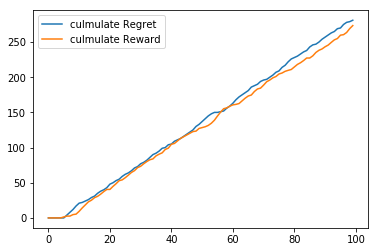

In [79]:
plt.plot(np.cumsum(C1.regret_history))
plt.plot(np.cumsum(C1.reward_sum_each_step))
plt.legend(["culmulate Regret", "culmulate Reward"])

In [80]:
len(C1.reward_sum_each_step)

100

In [81]:
C2 = copy.deepcopy(C)
ucb_agent = UCBAgent(C2.n_client, C2.n_commodity, recommendation_length=reco_length)
run(C2, ucb_agent, 100)

round 0
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [39 38 17 16 15]
recommandation_list [39 38 17 16 15]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 1
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [19 21 18 14 13]
recommandation_list [19 21 18 14 13]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 2
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [ 0  9 11 12  8]
recommandation_list [ 0  9 11 12  8]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 3
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [25 10  6  5  4]
recommandation_list [25 10  6  5  4]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 4
client_waiting_list []
comma

/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


 [ 0  5  9 10 14 15 16 18 22 23 25 28 29 31 39]
command_list [ 9 25  0]
client_waiting_list [ 0  0  7  8  0  0  0  0  0 17  0 19  0  0  0  0  0 30  0 32  0]
cart_list [ 0 30]
client_waiting_list [ 0  5  9 10 14 15 16 18 22 23 25 28 29 31 39]
click_list [ 9 25  0]
recommandation_list [ 6  9 25  0 30]
recommandation_list [ 6  9 25  0 30]
reward_list [0, 1.2, 1.2, 1.9, 0.7]
regret 2 	reward 5.0
round 49
client_waiting_list [ 7  8 10 14 15 16 17 18 19 22 23 28 29 31 39]
command_list [31 10]
client_waiting_list [ 0  0  0  0  0  0  0  0  0  0  0  0  0 30  0 32 33 34 37  0]
cart_list [0]
client_waiting_list [ 7  8 10 14 15 16 17 18 19 22 23 28 29 31 39]
click_list [31 10]
recommandation_list [ 9 25  0 31 10]
recommandation_list [ 9 25  0 31 10]
reward_list [0, 0, 0.7, 1.2, 1.2]
regret 3 	reward 3.0999999999999996
round 50
client_waiting_list [ 7  8 14 15 16 17 18 19 22 23 28 29 30 32 39]
command_list [32 15]
client_waiting_list [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 33 34 37  0]
cart_list

regret 3 	reward 3.0999999999999996
round 92
client_waiting_list [ 1  2  3  6  7  8  9 10 12 13 22 23 26 27 35 36 38]
command_list [9 8]
client_waiting_list [ 0  0  0  0  0  0  0  0  0  0 15 18 19  0  0 25  0  0 31 32  0  0  0]
cart_list [0]
client_waiting_list [ 1  2  3  6  7  8  9 10 12 13 22 23 26 27 35 36 38]
click_list [9 8]
recommandation_list [ 4 11  0  9  8]
recommandation_list [ 4 11  0  9  8]
reward_list [0, 0, 0.7, 1.2, 1.2]
regret 3 	reward 3.0999999999999996
round 93
client_waiting_list [ 1  2  3  6  7 10 12 13 15 18 22 23 26 27 31 35 36 38]
command_list [ 7  1 36]
client_waiting_list [ 0  0  0  5  0  0  0  0  0  0 16  0 19  0  0 25  0  0  0 32  0  0  0]
cart_list []
client_waiting_list [ 1  2  3  6  7 10 12 13 15 18 22 23 26 27 31 35 36 38]
click_list [ 7  1 36]
recommandation_list [ 9  8  7  1 36]
recommandation_list [ 9  8  7  1 36]
reward_list [0, 0, 1.2, 1.2, 1.2]
regret 2 	reward 3.5999999999999996
round 94
client_waiting_list [ 2  3  5  6 10 12 13 15 18 19 22 23 26 

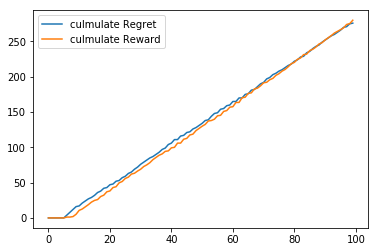

In [82]:
plt.plot(np.cumsum(C2.regret_history))
plt.plot(np.cumsum(C2.reward_sum_each_step))
plt.legend(["culmulate Regret", "culmulate Reward"])

In [83]:
C3 = copy.deepcopy(C)
ucb_adapted_agent = UCBAgent_Adapted(C3.n_client, C3.n_commodity, recommendation_length=reco_length)
run(C3, ucb_adapted_agent, 100)

round 0
recently_purchased_commodities set()
recommend_order [39 38 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1 18 19 20 30 37
 36 35 34 33 32 31 29 21 28 27 26 25 24 23 22  0]
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [39, 38, 17, 16, 15]
recommandation_list [39, 38, 17, 16, 15]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 1
recently_purchased_commodities set()
recommend_order [19 21 18 14 13 12 11 10  9  8  7  6  5  4  3  2  1 20  0 22 29 37 36 35
 34 33 32 31 30 28 27 26 25 24 23 38 15 16 17 39]
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [19, 21, 18, 14, 13]
recommandation_list [19, 21, 18, 14, 13]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 2
recently_purchased_commodities set()
recommend_order [ 0  9 11 12  8  7  6  5  4  3  2 20  1 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 

/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars



cart_list [27]
client_waiting_list [ 1  2  3 15 16 17 20 21 22 23 24 26 29 35 36 37 39]
click_list [ 1 36  2  3]
recommandation_list [27, 1, 36, 2, 3]
recommandation_list [27, 1, 36, 2, 3]
reward_list [0.7, 1.2, 1.2, 1.2, 1.2]
regret 1 	reward 5.5
round 30
recently_purchased_commodities {1, 2, 3, 36, 4, 5}
recommend_order [ 1 36  2  3  4  5 33 32 30 29 28  0 38 10 12 18 19 27 26 25 22 15 21 39
 16 17 24 23 20 14 13  9  8  7  6 11 31 34 35 37]
client_waiting_list [ 8 10 15 16 17 20 21 22 23 24 26 29 35 37 39]
command_list [29]
client_waiting_list [ 0  6  7  0  9  0  0  0  0 19  0  0  0  0  0 25  0 27 28  0 30 31 32 33
 34  0  0  0]
cart_list [33 32 30 28]
client_waiting_list [ 8 10 15 16 17 20 21 22 23 24 26 29 35 37 39]
click_list [29]
recommandation_list [33, 32, 30, 29, 28]
recommandation_list [33, 32, 30, 29, 28]
reward_list [0.7, 0.7, 0.7, 1.2, 0.7]
regret 4 	reward 4.0
round 31
recently_purchased_commodities {1, 2, 3, 36, 29}
recommend_order [ 1 36  2  3  4  5 29  0 25 10 12 18 3

reward_list [0, 0.7, 1.2, 1.2, 1.2]
regret 2 	reward 4.3
round 64
recently_purchased_commodities {27, 2, 10, 29}
recommend_order [ 6 13 29  2 10 26 27 19 25  0 30 38 28 18 12 33 32 37 31 34  1  3  4  9
 36  7  8  5 14 11 15 16 17 39 35 20 21 22 23 24]
client_waiting_list [ 7  9 15 16 17 18 19 20 22 23 25 30 35 38 39]
command_list [19 25]
client_waiting_list [ 0  1  0  8  0 12  0  0  0  0  0  0 21  0  0 24  0  0 34  0 37  0  0]
cart_list []
client_waiting_list [ 7  9 15 16 17 18 19 20 22 23 25 30 35 38 39]
click_list [19 25]
recommandation_list [6, 13, 26, 19, 25]
recommandation_list [6, 13, 26, 19, 25]
reward_list [0, 0, 0, 1.2, 1.2]
regret 3 	reward 2.4
round 65
recently_purchased_commodities {2, 10, 19, 25, 29}
recommend_order [19 29  2 10 25 27  0 32 30 33 28 12 38 18 34 37 31  7 11 13 14  8  5  6
  9  4  3  1 36 26 16 15 17 39 20 21 22 23 24 35]
client_waiting_list [ 7  8  9 15 16 17 18 20 22 23 24 30 35 38 39]
command_list [30]
client_waiting_list [ 0  1  3  0  0  0 12  0  0  0  0

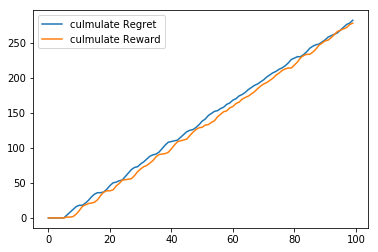

In [84]:
plt.plot(np.cumsum(C3.regret_history))
plt.plot(np.cumsum(C3.reward_sum_each_step))
plt.legend(["culmulate Regret", "culmulate Reward"])

In [85]:
C4 = copy.deepcopy(C)
thompson_agent = ThompsonAgent(C4.n_client, C4.n_commodity, recommendation_length=reco_length)
run(C4, thompson_agent, 100)

round 0
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [23 18 24 30 12]
recommandation_list [23 18 24 30 12]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 1
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [26  8  3 19 22]
recommandation_list [26  8  3 19 22]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 2
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [ 0 17  5 19 36]
recommandation_list [ 0 17  5 19 36]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 3
client_waiting_list []
command_list []
client_waiting_list []
cart_list []
client_waiting_list []
click_list []
recommandation_list [17  7 33  9 20]
recommandation_list [17  7 33  9 20]
reward_list [0, 0, 0, 0, 0]
regret 0 	reward 0
round 4
client_waiting_list []
comma

client_waiting_list [ 5  8 11 12 13 14 16 18 19 20 21 24 25 26 27 30 31 36 37 38]
command_list [38]
client_waiting_list [ 3  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 28  0  0  0  0  0]
cart_list [0 4]
client_waiting_list [ 5  8 11 12 13 14 16 18 19 20 21 24 25 26 27 30 31 36 37 38]
click_list [38]
recommandation_list [ 0 10 35 38  4]
recommandation_list [ 0 10 35 38  4]
reward_list [0.7, 0, 0, 1.2, 0.7]
regret 4 	reward 2.5999999999999996
round 31
client_waiting_list [ 5  8 11 12 13 14 16 18 19 20 21 24 25 26 27 30 31 36 37]
command_list [13 37]
client_waiting_list [ 2  3  4  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0 28 29  0  0  0
  0]
cart_list []
client_waiting_list [ 5  8 11 12 13 14 16 18 19 20 21 24 25 26 27 30 31 36 37]
click_list [13 37]
recommandation_list [13  6 37 39 35]
recommandation_list [13  6 37 39 35]
reward_list [1.2, 0, 1.2, 0, 0]
regret 3 	reward 2.4
round 32
client_waiting_list [ 3  4  5  8  9 12 14 16 18 19 20 21 24 25 26 27 28 30 31 36]
command_list [3

client_waiting_list [ 2  3  5  6  8  9 12 15 17 19 20 21 26 30 31 36 37 38 39]
command_list [30 37]
client_waiting_list [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
cart_list [0]
client_waiting_list [ 2  3  5  6  8  9 12 15 17 19 20 21 26 30 31 36 37 38 39]
click_list [30 37]
recommandation_list [35 30  0 37 23]
recommandation_list [35 30  0 37 23]
reward_list [0, 1.2, 0.7, 1.2, 0]
regret 3 	reward 3.0999999999999996
round 79
client_waiting_list [ 0  2  3  5  6  8  9 10 12 15 17 19 20 21 26 31 36 38 39]
command_list [ 0 10]
client_waiting_list [ 0  0  0  0  0  7  0  0  0  0  0 16  0  0  0  0 22  0  0  0  0  0]
cart_list [22  0]
client_waiting_list [ 0  2  3  5  6  8  9 10 12 15 17 19 20 21 26 31 36 38 39]
click_list [ 0 10]
recommandation_list [22  0 10 34 35]
recommandation_list [22  0 10 34 35]
reward_list [0.7, 1.9, 1.2, 0, 0]
regret 3 	reward 3.8
round 80
client_waiting_list [ 2  3  5  6  7  8  9 12 15 17 19 20 21 26 31 36 38 39]
command_list [2]
client_waiti

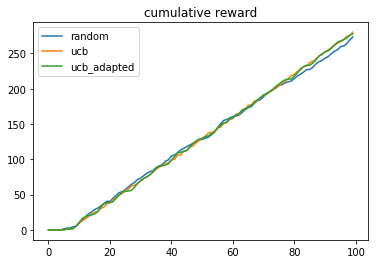

In [86]:
plt.plot(np.cumsum(C1.reward_sum_each_step), label='random')
plt.plot(np.cumsum(C2.reward_sum_each_step), label='ucb')
plt.plot(np.cumsum(C3.reward_sum_each_step), label='ucb_adapted')
plt.title('cumulative reward')
plt.legend()

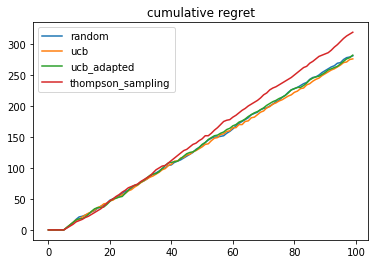

In [87]:
plt.plot(np.cumsum(C1.regret_history), label = 'random')
plt.plot(np.cumsum(C2.regret_history), label = 'ucb')
plt.plot(np.cumsum(C3.regret_history), label = 'ucb_adapted')
plt.plot(np.cumsum(C4.regret_history), label = 'thompson_sampling')

plt.title('cumulative regret')
plt.legend()

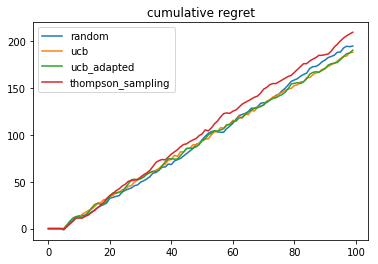

In [88]:
plt.plot(np.cumsum(C1.regret_moreinfo_history), label = 'random')
plt.plot(np.cumsum(C2.regret_moreinfo_history), label = 'ucb')
plt.plot(np.cumsum(C3.regret_moreinfo_history), label = 'ucb_adapted')
plt.plot(np.cumsum(C4.regret_moreinfo_history), label = 'thompson_sampling')

plt.title('cumulative regret')
plt.legend()

In [56]:
def run_with_revenue(env, agent, n):
    for i in range(n):
        print('round', i)
        active_clients = env.get_clients(1)
        
        for c in active_clients:
            env.update_desire(c, rate_rise=0.5)
            recomedation_list = agent.recommend(c)
            articles_buy = env.return_command(c, recomedation_list)
            
            revenue_list = env.get_revenue(c, recomedation_list, articles_buy)
            regret = env.get_regret(c, recomedation_list, revenue_list)
            print('regret', regret, '\treward', sum(revenue_list))
            env.do_purchase(c, articles_buy)
            env.update_history(revenue_list, regret, revenue_list)
            agent.update_state(c, recomedation_list, revenue_list, articles_buy)

In [57]:
CM1 = copy.deepcopy(C)
random_agent = RandomAgent(CM1.n_client, CM1.n_commodity, recommendation_length=5)
run_with_revenue(CM1, random_agent, 100)

round 0
client_waiting_list []
command_list []
recommandation_list [26 28  9 35  6]
regret 0 	reward 0
round 1
client_waiting_list []
command_list []
recommandation_list [25 14 16 33  5]
regret 0 	reward 0
round 2
client_waiting_list []
command_list []
recommandation_list [37 35 30 32  4]
regret 0 	reward 0
round 3
client_waiting_list []
command_list []
recommandation_list [21  8 39 37 23]
regret 0 	reward 0
round 4
client_waiting_list []
command_list []
recommandation_list [ 8 16 23  4 32]
regret 0 	reward 0
round 5
client_waiting_list []
command_list []
recommandation_list [18  8 14  4 22]
regret 0 	reward 0
round 6
client_waiting_list [20 21 22 23 24 32 33 34]
command_list [24 32]
recommandation_list [31  2 24  6 32]
regret 3 	reward 2
round 7
client_waiting_list [ 0  1 20 21 22 23 30 31 33 34 35 36 37 38 39]
command_list [36 23 22]
recommandation_list [36 29 23 22 16]
regret 2 	reward 3
round 8
client_waiting_list [ 0  1  2  3  4 20 21 30 31 33 34 35 37 38 39]
command_list [21 30 3

In [58]:
CM2 = copy.deepcopy(C)
ucb_agent = UCBAgent(CM2.n_client, CM2.n_commodity, recommendation_length=reco_length)
run_with_revenue(CM2, ucb_agent, 100)

round 0
client_waiting_list []
command_list []
recommandation_list [39 38 17 16 15]
regret 0 	reward 0
round 1
client_waiting_list []
command_list []
recommandation_list [19 21 18 14 13]
regret 0 	reward 0
round 2
client_waiting_list []
command_list []
recommandation_list [ 0  9 11 12  8]
regret 0 	reward 0
round 3
client_waiting_list []
command_list []
recommandation_list [25 10  6  5  4]
regret 0 	reward 0
round 4
client_waiting_list []
command_list []
recommandation_list [ 1 29  3 20  2]
regret 0 	reward 0
round 5
client_waiting_list []
command_list []
recommandation_list [26 24 37 36 35]
regret 0 	reward 0
round 6
client_waiting_list [20 21 22 23 24 32 33 34]
command_list [34 33 32]
recommandation_list [27  7 34 33 32]
regret 2 	reward 3
round 7
client_waiting_list [ 0  1 20 21 22 23 24 30 31 35 36 37 38 39]
command_list [31 30 22 23]
recommandation_list [31 30 28 22 23]
regret 1 	reward 4
round 8
client_waiting_list [ 0  1  2  3  4 20 21 24 35 36 37 38 39]
command_list []
recomman

/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


In [59]:
CM3 = copy.deepcopy(C)
ucb_adapted_agent = UCBAgent_Adapted(CM3.n_client, CM3.n_commodity, recommendation_length=reco_length)
run_with_revenue(CM3, ucb_adapted_agent, 100)

round 0
recently_purchased_commodities set()
recommend_order [39 38 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1 18 19 20 30 37
 36 35 34 33 32 31 29 21 28 27 26 25 24 23 22  0]
client_waiting_list []
command_list []
recommandation_list [39, 38, 17, 16, 15]
regret 0 	reward 0
round 1
recently_purchased_commodities set()
recommend_order [19 21 18 14 13 12 11 10  9  8  7  6  5  4  3  2  1 20  0 22 29 37 36 35
 34 33 32 31 30 28 27 26 25 24 23 38 15 16 17 39]
client_waiting_list []
command_list []
recommandation_list [19, 21, 18, 14, 13]
regret 0 	reward 0
round 2
recently_purchased_commodities set()
recommend_order [ 0  9 11 12  8  7  6  5  4  3  2 20  1 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 10 39 13 14 15 16 17 18 38 21 19]
client_waiting_list []
command_list []
recommandation_list [0, 9, 11, 12, 8]
regret 0 	reward 0
round 3
recently_purchased_commodities set()
recommend_order [25 10  6  5  4  3  2 20  1 22 23 24 26 27 28 29 30 31 32 33 34 35 36 37
  7  8 39  9 19 11 1

/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars


{9, 12, 37, 14}
recommend_order [14 37 12 11  9  2  3  5  6 36 35  1  4 25 29 26 27 28 38 39  0 23 24 34
 33 20 32 21 22 31 30 10 18  7  8 17 13 15 16 19]
client_waiting_list [ 0  1  2  3  4  5  6 10 13 20 21 22 23 24 27 28 35 36 38 39]
command_list [2 3 5 6]
recommandation_list [11, 2, 3, 5, 6]
regret 1 	reward 4
round 75
recently_purchased_commodities {2, 3, 5, 6, 9}
recommend_order [ 5  2 12  9  6  3 14 37  1  4 35 36 29 28 27 26 25 38 39  0 20 24 34 33
 32 31 30 23 22 21 11 10 18  8  7 13 15 16 17 19]
client_waiting_list [ 0  1  4  7 10 13 20 21 22 23 24 27 28 30 32 35 36 38 39]
command_list [1 4]
recommandation_list [12, 14, 37, 1, 4]
regret 3 	reward 2
round 76
recently_purchased_commodities {1, 2, 3, 4, 5, 6}
recommend_order [ 6  9  2  3  5  1  4 36 35 29 28 27 26 25 38 39 21 20  0 22 23 34 33 32
 31 30 24 37 10 11 12 14  8  7 13 15 16 17 18 19]
client_waiting_list [ 0  7  8 10 13 20 21 22 23 24 27 28 30 31 32 35 36 38 39]
command_list [36 35 28]
recommandation_list [9, 36, 35, 

In [60]:
CM4 = copy.deepcopy(C)
thompson_agent = ThompsonAgent(CM4.n_client, CM4.n_commodity, recommendation_length=reco_length)
run_with_revenue(CM4, thompson_agent, 100)

round 0
client_waiting_list []
command_list []
recommandation_list [ 1 14 29 28 27]
regret 0 	reward 0
round 1
client_waiting_list []
command_list []
recommandation_list [19 10 36 20  9]
regret 0 	reward 0
round 2
client_waiting_list []
command_list []
recommandation_list [15  2 32  4 24]
regret 0 	reward 0
round 3
client_waiting_list []
command_list []
recommandation_list [ 5 23 12 18 33]
regret 0 	reward 0
round 4
client_waiting_list []
command_list []
recommandation_list [ 0 25 18 13 26]
regret 0 	reward 0
round 5
client_waiting_list []
command_list []
recommandation_list [ 3 21 34 20 11]
regret 0 	reward 0
round 6
client_waiting_list [20 21 22 23 24 32 33 34]
command_list [22 24]
recommandation_list [22 24  7 30 37]
regret 3 	reward 2
round 7
client_waiting_list [ 0  1 20 21 23 30 31 32 33 34 35 36 37 38 39]
command_list [21]
recommandation_list [ 4 10 21  2 22]
regret 4 	reward 1
round 8
client_waiting_list [ 0  1  2  3  4 20 23 30 31 32 33 34 35 36 37 38 39]
command_list [39 38 3

client_waiting_list [ 0  2  5  6  7  8  9 11 13 16 18 20 28 35 36 39]
command_list []
recommandation_list [34 14 17 31 19]
regret 5 	reward 0
round 74
client_waiting_list [ 0  2  5  6  7  8  9 11 13 16 18 20 28 35 36 39]
command_list [35  5]
recommandation_list [30 35 32  5  4]
regret 3 	reward 2
round 75
client_waiting_list [ 0  2  6  7  8  9 10 11 13 16 18 20 21 22 28 31 32 36 39]
command_list [18 20]
recommandation_list [27 37 18 20 24]
regret 3 	reward 2
round 76
client_waiting_list [ 0  2  6  7  8  9 10 11 13 16 21 22 28 31 32 33 36 37 38 39]
command_list [22  8 38 33]
recommandation_list [22  8 38 33  3]
regret 1 	reward 4
round 77
client_waiting_list [ 0  2  6  7  9 10 13 16 21 23 28 31 32 36 37 39]
command_list [36]
recommandation_list [ 4 30 33  1 36]
regret 4 	reward 1
round 78
client_waiting_list [ 0  2  3  6  7  9 10 12 13 16 21 23 24 28 31 32 37 39]
command_list [32  2 23]
recommandation_list [30 32 20  2 23]
regret 2 	reward 3
round 79
client_waiting_list [ 0  1  3  6  7 

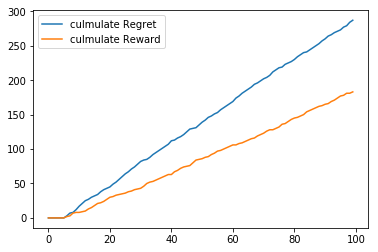

In [61]:
plt.plot(np.cumsum(CM4.regret_history))
plt.plot(np.cumsum(CM4.reward_sum_each_step))
plt.legend(["culmulate Regret", "culmulate Reward"])

In [62]:
CM5 = copy.deepcopy(C)
adapted_thompson_agent = AdaptedThompsonAgent(CM5.n_client, CM5.n_commodity, recommendation_length=reco_length)
run_with_revenue(CM5, adapted_thompson_agent, 100)

round 0
recently_purchased_commodities set()
recommend_order [ 5 29 38 24 23 32 15 10 37  6 18 28 36  4  2  1  3 21 31 13  8 22 39 14
 12 20  7 27 26 11  0 16 33 25 19 35 17 30  9 34]
client_waiting_list []
command_list []
recommandation_list [5, 29, 38, 24, 23]
regret 0 	reward 0
round 1
recently_purchased_commodities set()
recommend_order [15 31 37 25 18 38 28 12 33 14  9 21  0 39  4  8 36  2  6 29 24 35  3  1
 16 22 27 10 20 26 34 11 13 17  5  7 23 19 30 32]
client_waiting_list []
command_list []
recommandation_list [15, 31, 37, 25, 18]
regret 0 	reward 0
round 2
recently_purchased_commodities set()
recommend_order [ 8  3 19 39 22 13  6 14  7 12 11  2 17 33 37 24 31 27 30 18 36 35 23  9
 38 20 34 21 32  5 10  0 28 15 25 16 26 29  1  4]
client_waiting_list []
command_list []
recommandation_list [8, 3, 19, 39, 22]
regret 0 	reward 0
round 3
recently_purchased_commodities set()
recommend_order [23 30  2  9 20 11 35 28 12  1  6  7 10 36 34 32 22 24  3  4 13 17 39 15
 26  0 18 31 33  8 2

recently_purchased_commodities {1, 38, 22, 30, 31}
recommend_order [13 26 22  4  1 21 27 12  2  6 30 34 38 33 20 10  0 16 39 37 14 11 19 36
 31 32 35  5 18  7  8 28 24  3 15 29 17  9 25 23]
client_waiting_list [ 0  6 12 16 18 19 20 21 23 27 28 32 35 39]
command_list [21 27]
recommandation_list [13, 26, 4, 21, 27]
regret 3 	reward 2
round 64
recently_purchased_commodities {27, 21, 38}
recommend_order [21 10  3 31  2 38 17 37 34 32 39 13  5 33  6 20 14  1 22 36  8  0 30 35
  7 15 11 29 16 27  4 18 12  9 23 26 25 19 24 28]
client_waiting_list [ 0  2  6 12 16 18 19 20 23 28 32 35 39]
command_list [2]
recommandation_list [10, 3, 31, 2, 17]
regret 4 	reward 1
round 65
recently_purchased_commodities {2, 27, 21}
recommend_order [33 26 35 20 15 10  7  1 38 36 22 39 37 30  0 32 28 31 16 18 12 21 13 23
 24  8 25  4  3  5 14 34  6  2 11  9 27 17 29 19]
client_waiting_list [ 0  6 12 16 18 19 20 23 28 32 35 36 39]
command_list [35 20]
recommandation_list [33, 26, 35, 20, 15]
regret 3 	reward 2
round

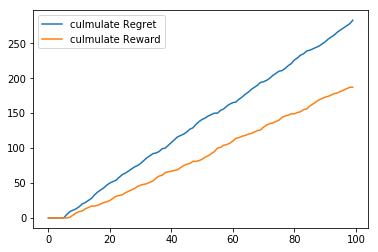

In [63]:
plt.plot(np.cumsum(CM5.regret_history))
plt.plot(np.cumsum(CM5.reward_sum_each_step))
plt.legend(["culmulate Regret", "culmulate Reward"])

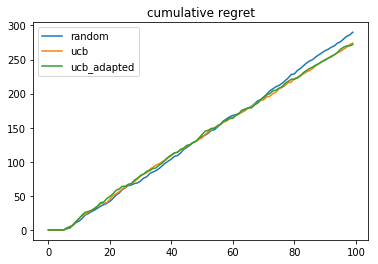

In [64]:
plt.plot(np.cumsum(CM1.regret_history), label = 'random')
plt.plot(np.cumsum(CM2.regret_history), label = 'ucb')
plt.plot(np.cumsum(CM3.regret_history), label = 'ucb_adapted')
plt.title('cumulative regret')
plt.legend()

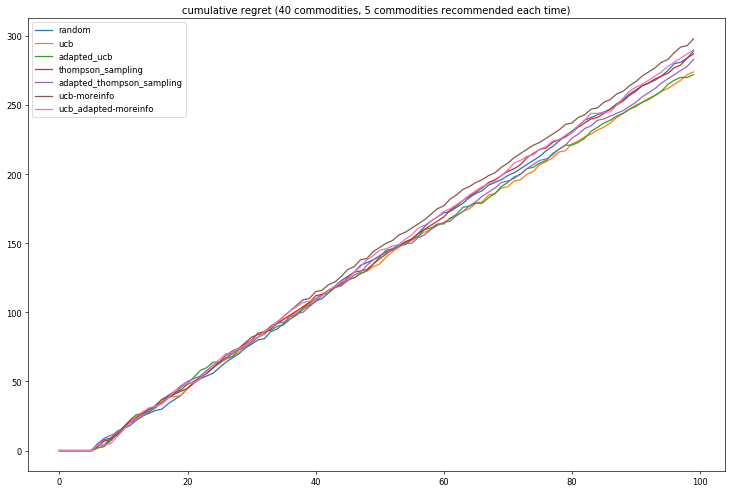

In [65]:
plt.figure(figsize=(15,10),dpi=60)
#plt.plot(np.cumsum(CM1.regret_history), label = 'random')
plt.plot(np.cumsum(C1.regret_history), label = 'random')

plt.plot(np.cumsum(CM2.regret_history), label = 'ucb')
plt.plot(np.cumsum(CM3.regret_history), label = 'adapted_ucb')
plt.plot(np.cumsum(CM4.regret_history), label = 'thompson_sampling')
plt.plot(np.cumsum(CM5.regret_history), label = 'adapted_thompson_sampling')

plt.plot(np.cumsum(C2.regret_history), label = 'ucb-moreinfo')
plt.plot(np.cumsum(C3.regret_history), label = 'ucb_adapted-moreinfo')

plt.title('cumulative regret (40 commodities, 5 commodities recommended each time)')
plt.legend()

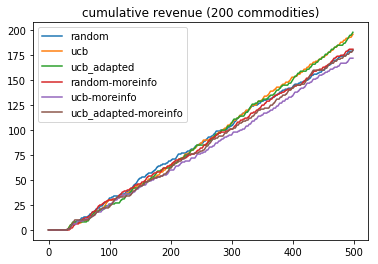

In [66]:
plt.plot(np.cumsum(CM1.revenue_history), label = 'random')
plt.plot(np.cumsum(CM2.revenue_history), label = 'ucb')
plt.plot(np.cumsum(CM3.revenue_history), label = 'ucb_adapted')

plt.plot(np.cumsum(C1.revenue_history), label = 'random-moreinfo')
plt.plot(np.cumsum(C2.revenue_history), label = 'ucb-moreinfo')
plt.plot(np.cumsum(C3.revenue_history), label = 'ucb_adapted-moreinfo')

plt.title('cumulative revenue (200 commodities)')
plt.legend()


In [30]:
np.random.choice([1,2,3], 2, replace=False)

array([2, 1])

In [31]:
C.update_desire(C.get_clients(1), rate_rise=0.5)

TypeError: only integer scalar arrays can be converted to a scalar index

In [32]:
C.desire_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [95]:
C.get_waiting_list(0)

array([], dtype=float64)

In [85]:
np.array([[1], [1,2]])

array([list([1]), list([1, 2])], dtype=object)

In [15]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.vstack([a,b])

array([[1, 2, 3],
       [4, 5, 6]])

In [17]:
a = 5
3<a<6

True